In [17]:
import requests
import csv
import pytz
import time
from datetime import datetime, timedelta

In [18]:
start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  ['198.32.64.12', '199.7.83.42']
prefix6 = ['2001:500:3::42','2001:500:9f::42']

### helper methods

In [19]:
def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_state = []
    if data:
        for item in data:
            route_info = {
                'peer': item['path'][0],
                'root': item['path'][-1],
                'as_path': list(deduplicate(item['path']))
            }
            bgp_state.append(route_info)

    peer = [item['peer'] for item in bgp_state]

    return bgp_state, peer

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

def get_peers_stat(peers, bgp_state4, bgp_state6):
    result = []
    for peer in sorted(peers):
        path4 = [d['as_path'] for d in bgp_state4 if d['peer'] == peer][0]
        path6 = [d['as_path'] for d in bgp_state6 if d['peer'] == peer][0]
        similar = 1 if path4 == path6 else 0
        temp_res = {
            'peer': peer,
            'similar': similar,
            'path4': path4,
            'path6': path6
        }
        result.append(temp_res)

    return result

### calculation

In [20]:
utc = pytz.utc
with open('l-root-mutual-as-path-stats.csv', 'w', newline='') as output_file:
    writer = csv.writer(output_file, delimiter=',')
    # csv header first
    writer.writerow(['time', 'identical', 'diff', 'v4_longer', 'v4_shorter'])
    cur_date = start
    while cur_date <= stop:
        print(cur_date)
        
        utc_dt = utc.localize(cur_date)
        timestamp = int(time.mktime(utc_dt.timetuple()))
        
        pfx4 = prefix4[0] if timestamp < 1193875200 else prefix4[1]
        pfx6 = prefix6[0] if timestamp < 1458691200 else prefix6[1]    
        
        bgp_state4, peer4 = get_peers(pfx4, timestamp)
        bgp_state6, peer6 = get_peers(pfx6, timestamp)
        
        mutual_peers = list(set(peer4) & set(peer6))
        
        mutual_peers_stat = get_peers_stat(mutual_peers, bgp_state4, bgp_state6)
        
        time_str = cur_date.strftime('%Y-%m-%d')
        result_all = len([i['peer'] for i in mutual_peers_stat])
        result_identical = len([i['peer'] for i in mutual_peers_stat if i['similar'] == 1])
        result_diff = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) == len(i['path6']) and i['similar'] == 0])
        result_v4_longer = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) > len(i['path6'])])
        result_v4_shorter = len([i['peer'] for i in mutual_peers_stat if len(i['path4']) < len(i['path6'])])
        
        writer.writerow((time_str, result_identical, result_diff, result_v4_longer, result_v4_shorter))
        
        year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
        month = 1 if cur_date.month == 12 else cur_date.month + 1
        cur_date = datetime(year, month, 1, 1, 0, 0)
    
    

2008-03-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=1204329600
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:3::42&timestamp=1204329600
2008-04-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=1207008000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:3::42&timestamp=1207008000
2008-05-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=1209600000
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:3::42&timestamp=1209600000
2008-06-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=1212278400
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:3::42&timestamp=1212278400
2008-07-01 01:00:00
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=12148704

In [21]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

In [22]:
df = pd.read_csv('l-root-mutual-as-path-stats.csv', index_col=0)
df

,identical,diff,v4_longer,v4_shorter
time,,,,
2008-03-01,0,0,0,0
2008-04-01,0,0,0,0
2008-05-01,1,0,0,0
2008-06-01,0,0,0,0
2008-07-01,1,0,0,2
2008-08-01,0,0,0,0
2008-09-01,0,0,0,0
2008-10-01,0,0,0,0
2008-11-01,0,0,0,0


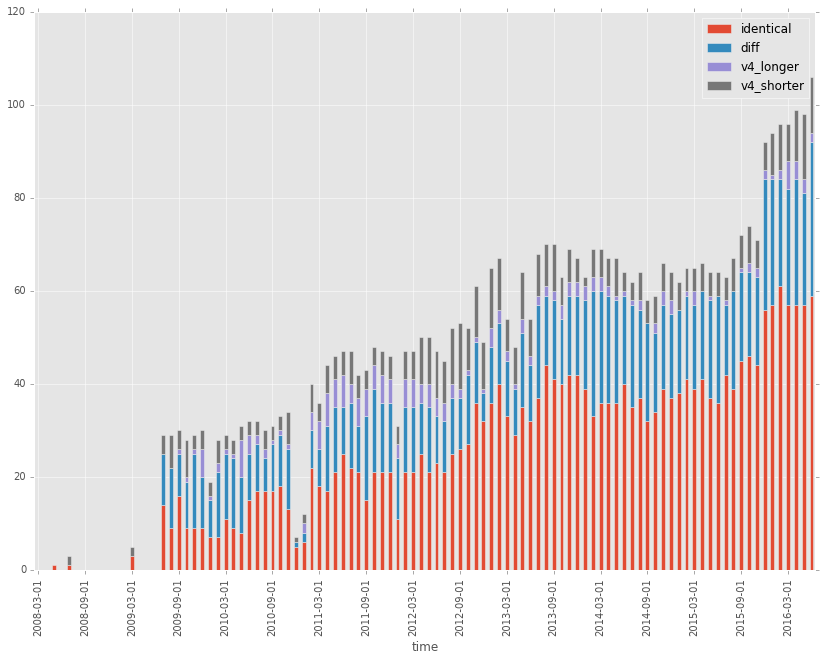

In [23]:
plot = df.plot.bar(stacked=True, figsize=(14,10))

n = 6

ticks = plot.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in plot.xaxis.get_ticklabels()]
plot.xaxis.set_ticks(ticks[::n])
plot.xaxis.set_ticklabels(ticklabels[::n])

# RQ: How different is IPv4 and IPv6 catchment areas?

## RQ.1 IPv4/IPv6 peer degree distribution?

In [3]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests

# matplotlib.style.use('ggplot')

timestamp = 1464739200 # 2013-06-01
# url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
prefix4 =  '199.7.83.42'
prefix6 = '2001:500:3::42'

Find out the mutual peers

In [4]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    print('get_peers {}'.format(url))
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
#             bgp_data[item['path'][0]] = list(deduplicate(item['path']))
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers

data4, peer4 = get_peers(prefix4, timestamp)
data6, peer6 = get_peers(prefix6, timestamp)

mutual_peers = list(set(peer4) & set(peer6))

get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=199.7.83.42&timestamp=1464739200
get_peers https://stat.ripe.net/data/bgp-state/data.json?resource=2001:500:3::42&timestamp=1464739200


then, find mutual peers with different path

In [5]:
mutual_peers_diff = {}

for peer in mutual_peers:
    if data4[peer]['path'] != data6[peer]['path']:
        mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}

data processing

In [6]:
from pandas import DataFrame

processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')
for index, row in processed_data.iterrows():
    processed_data.set_value(index, 'len4', len(row['path4']))
    processed_data.set_value(index, 'len6', len(row['path6']))
processed_data

,collector,path4,path6,len4,len6
553,"Frankfurt, Germany","[553, 12731, 20144]","[553, 6939, 20144]",3.0,3.0
680,"Frankfurt, Germany","[680, 6939, 20144]","[680, 3356, 20144]",3.0,3.0
1853,"VIX, Vienna","[1853, 2852, 20144]","[1853, 8218, 20144]",3.0,3.0
3257,"Frankfurt, Germany","[3257, 20144]","[3257, 12883, 20144]",2.0,3.0
6453,"AMS-IX and NL-IX, Amsterdam","[6453, 8151, 28496, 20144]","[6453, 8966, 20144]",4.0,3.0
6720,"VIX, Vienna","[6720, 6939, 20144]","[6720, 8218, 20144]",3.0,3.0
8596,"VIX, Vienna","[8596, 6939, 20144]","[8596, 8218, 20144]",3.0,3.0
8758,"SwissIX, Zurich","[8758, 6939, 20144]","[8758, 25091, 20144]",3.0,3.0
9002,"Moscow, Russia","[9002, 38880, 20144]","[9002, 49605, 20144]",3.0,3.0
9189,"Frankfurt, Germany","[9189, 12731, 20144]","[9189, 49605, 20144]",3.0,3.0


### Plot

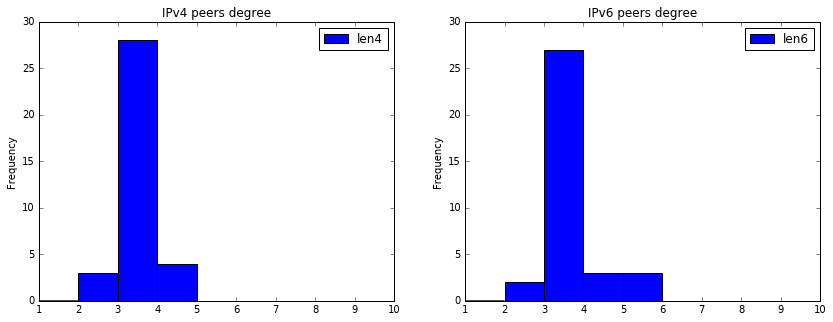

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2)

processed_data[['len4']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[0], ylim=(0,30), title='IPv4 peers degree')
processed_data[['len6']].plot.hist(bins=[1,2,3,4,5,6,7,8,9,10], figsize=(14,5), ax=axes[1], ylim=(0,30), title='IPv6 peers degree')

plt.show()

## RQ.2 AS path average length?

In [9]:
avg4 = processed_data['len4'].mean()
avg6 = processed_data['len6'].mean()

print('IPv4 average path length: {}'.format(avg4))
print('IPv6 average path length: {}'.format(avg6))

IPv4 average path length: 3.0285714285714285
IPv6 average path length: 3.2


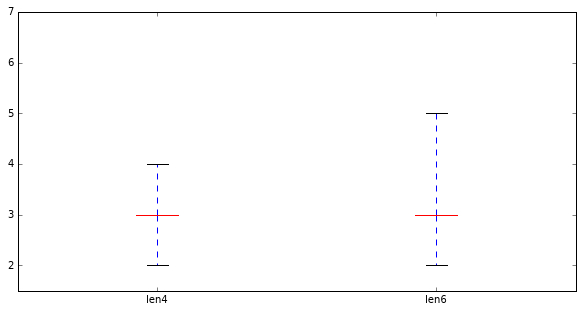

In [10]:
processed_data[['len4', 'len6']].plot.box(figsize=(10,5), ylim=(1.5,7))
plt.show()

## RQ.3 ASes most frequently seen?

### IPv4

In [11]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

res = []

for item in processed_data['path4']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv4 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 


Most frequently seen ASes in IPv4 AS paths:
6939	12
12731	4
25091	3
23148	2
13238	2
3257	2
38880	1
13004	1
2852	1
49605	1
9002	1
35054	1
28496	1
21011	1
42708	1
8151	1
8928	1


Most frequently seen per degree (degree is as seen from Root ASN)

In [12]:
max = processed_data['len4'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path4']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	6939	12
	12731	4
	25091	3
	3257	3
	23148	2
	13238	2
	38880	1
	31424	1
	2852	1
	49605	1
	13004	1
	29608	1
	28496	1
	21011	1
	8928	1
(*) Hop 2:
	9002	2
	6720	1
	25152	1
	50763	1
	25220	1
	29686	1
	15435	1
	31122	1
	8596	1
	8151	1
	29636	1
	48166	1
	20764	1
	57821	1
	47872	1
	20640	1
	9189	1
	13030	1
	62567	1
	680	1
	553	1
	31019	1
	35054	1
	34288	1
	41497	1
	28917	1
	8758	1
	49463	1
	42708	1
	12859	1
	1853	1
(*) Hop 3:
	202194	1
	196621	1
	6453	1
	57381	1


### IPv6

In [14]:
res = []

for item in processed_data['path6']:
    # exclude origin AS and probe AS
    for i in item[1:-1]:
        res.append(i)

results = most_common(res)
print('Most frequently seen ASes in IPv6 AS paths:')
for result in results:
    print('{}\t{}'.format(result[0], result[1])) 

Most frequently seen ASes in IPv6 AS paths:
8218	8
6939	6
25091	3
49605	3
24961	2
39138	2
8954	2
12883	2
33891	2
12731	2
8966	1
2854	1
5580	1
20562	1
42708	1
47445	1
23148	1
48635	1
3356	1
16735	1


most frequently seen ASes per degree

In [15]:
max = processed_data['len6'].max()

counter = -2
while counter >= -max:
    temp = []
    for item in processed_data['path6']:
        try:
            temp.append(item[counter])
        except IndexError:
            pass
    print('(*) Hop {}:'.format(-counter - 1))
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))
    counter -= 1
        

(*) Hop 1:
	8218	8
	6939	6
	25091	3
	49605	3
	39138	2
	8954	2
	12883	2
	12731	2
	47872	1
	8966	1
	23148	1
	47445	1
	48166	1
	3356	1
	16735	1
(*) Hop 2:
	24961	2
	6720	1
	50763	1
	25220	1
	29686	1
	15435	1
	5580	1
	42708	1
	31122	1
	8596	1
	25152	1
	41497	1
	31424	1
	57821	1
	20640	1
	48635	1
	9189	1
	2854	1
	62567	1
	680	1
	553	1
	9002	1
	31019	1
	202194	1
	34288	1
	29608	1
	6453	1
	8758	1
	3257	1
	12859	1
	1853	1
	28917	1
(*) Hop 3:
	33891	2
	29636	1
	20562	1
	20764	1
	57381	1
(*) Hop 4:
	196621	1
	13030	1
	49463	1


## RQ.4 For shorter IPv6 path, which ASes frequently appear as transit?

In [17]:
temp= []
for item in processed_data.iterrows():
#     print(item[1]['path4'])
    if item[1]['len4'] > item[1]['len6']:
#         print('v4: {}\tv6: {}'.format(item[1]['path4'], item[1]['path6']))
        for asn in item[1]['path6'][1:-1]:
            temp.append(asn)

results = most_common(temp)
for result in results:
    print('{}\t{}'.format(result[0], result[1]))

25091	1
8966	1


## RQ.5 For peers with same path length but different path, how different is it?

calculate the percentage of different AS hop, and find out which ASes are frequently appear in the IPv6 path

In [18]:
temp = []
for item in processed_data.iterrows():
    if len(item[1]['path4']) == len(item[1]['path6']):
#         print('v4:{}\t\t\tv6:{}'.format(item[1]['path4'][1:-1], item[1]['path6'][1:-1]))
        diff_counter = 0
        path_length = len(item[1]['path4'])
        for i in range(0, path_length):
            if item[1]['path4'][i] != item[1]['path6'][i]:
                temp.append(item[1]['path6'][i])
                diff_counter += 1
        diff_pct = (diff_counter / path_length) * 100
        print('Peer {}: \tlength:{} \tdifference: {}%'.format(item[0], path_length, diff_pct))

print('\nMost common ASes appear in IPv6 path that differs with IPv4 path')
results = most_common(temp)
for result in results:
    print('\t{}\t{}'.format(result[0], result[1]))

Peer 553: 	length:3 	difference: 33.33333333333333%
Peer 680: 	length:3 	difference: 33.33333333333333%
Peer 1853: 	length:3 	difference: 33.33333333333333%
Peer 6720: 	length:3 	difference: 33.33333333333333%
Peer 8596: 	length:3 	difference: 33.33333333333333%
Peer 8758: 	length:3 	difference: 33.33333333333333%
Peer 9002: 	length:3 	difference: 33.33333333333333%
Peer 9189: 	length:3 	difference: 33.33333333333333%
Peer 12859: 	length:3 	difference: 33.33333333333333%
Peer 15435: 	length:3 	difference: 33.33333333333333%
Peer 20640: 	length:3 	difference: 33.33333333333333%
Peer 25152: 	length:3 	difference: 33.33333333333333%
Peer 25220: 	length:3 	difference: 33.33333333333333%
Peer 28917: 	length:3 	difference: 33.33333333333333%
Peer 29686: 	length:3 	difference: 33.33333333333333%
Peer 31019: 	length:3 	difference: 33.33333333333333%
Peer 31122: 	length:3 	difference: 33.33333333333333%
Peer 34288: 	length:3 	difference: 33.33333333333333%
Peer 41497: 	length:3 	difference: 33.

## RQ.6 Can we correlate the path difference to their physical location? (based on the location of RIS collector)?

In [19]:
peer_location = processed_data.groupby('collector')
peer_location['collector'].count().sort_values(ascending=False)

collector
Frankfurt, Germany             8
SwissIX, Zurich                5
AMS-IX and NL-IX, Amsterdam    4
VIX, Vienna                    3
RIPE NCC, Amsterdam            3
Moscow, Russia                 3
France-IX, Paris               3
New York (NY), USA             2
Stockholm, Sweden              1
Milan, Italy                   1
Miami, USA                     1
LINX, London                   1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv6 path?

In [20]:
v6_shorter = processed_data[processed_data.len4 > processed_data.len6].groupby('collector')
v6_shorter['collector'].count().sort_values(ascending=False)

collector
SwissIX, Zurich                1
Stockholm, Sweden              1
Frankfurt, Germany             1
AMS-IX and NL-IX, Amsterdam    1
Name: collector, dtype: int64

### which collectors see the most peers with shorter IPv4 path?

In [21]:
v4_shorter = processed_data[processed_data.len4 < processed_data.len6].groupby('collector')
v4_shorter['collector'].count().sort_values(ascending=False)

collector
SwissIX, Zurich        2
RIPE NCC, Amsterdam    1
New York (NY), USA     1
Moscow, Russia         1
LINX, London           1
Frankfurt, Germany     1
France-IX, Paris       1
Name: collector, dtype: int64

# RQ: How do IPv4 and IPv6 catchment areas evolve over time?
Note that here we only use mutual peers that have different IPv4/IPv6 path

## RQ.1 IPv4/IPv6 peer degree distribution over time?

In [1]:
%matplotlib inline
from ggplot import *
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import requests
from datetime import datetime
import pytz
import time
import csv
from pandas import DataFrame

utc = pytz.utc

start = datetime(2008, 3, 1, 1, 0, 0)
stop = datetime(datetime.today().year, datetime.today().month, 1, 1, 0, 0)
# stop = datetime(2014, 6, 1, 1, 0, 0)
prefix4 =  '199.7.83.42'
prefix6 = ['2001:500:3::42','2001:500:9f::42']

csv_dir = 'datasets/l/'

*Helper methods*

In [2]:
col_map = {
    '00': 'RIPE NCC, Amsterdam',
    '01': 'LINX, London',
    '02': 'SFINX, Paris',
    '03': 'AMS-IX and NL-IX, Amsterdam',
    '04': 'CIXP, Geneva',
    '05': 'VIX, Vienna',
    '06': 'Otemachi, Japan',
    '07': 'Stockholm, Sweden',
    '08': 'San Jose (CA), USA',
    '09': 'Zurich, Switzerland',
    '10': 'Milan, Italy',
    '11': 'New York (NY), USA',
    '12': 'Frankfurt, Germany',
    '13': 'Moscow, Russia',
    '14': 'Palo Alto, USA',
    '15': 'Sao Paulo, Brazil',
    '16': 'Miami, USA',
    '18': 'CATNIX, Barcelona',
    '19': 'NAP Africa JB, Johannesburg',
    '20': 'SwissIX, Zurich',
    '21': 'France-IX, Paris',
}


def deduplicate(items):
    seen = set()
    for item in items:
        if item not in seen:
            yield item
            seen.add(item)

def get_peers(prefix, timestamp):
    url = 'https://stat.ripe.net/data/bgp-state/data.json?resource={0}&timestamp={1}'.format(prefix, timestamp)
    data = requests.get(url).json()
    data = data['data']['bgp_state']

    bgp_data = {}
    peers = []
    if data:
        for item in data:
            coll = item['source_id'].split('-')[0]
            bgp_data[item['path'][0]] = {'path': list(deduplicate(item['path'])), 'collector': coll}
            peers.append(item['path'][0])
    return bgp_data, peers


def get_mutual_peer_with_diff_paths(timestamp):
    """
    get mutual peer with different IPv4/IPv6 paths
    """
    data4, peer4 = get_peers(prefix4, timestamp)
    if timestamp < 1458691200:
        data6, peer6 = get_peers(prefix6[0], timestamp)
    else:
        data6, peer6 = get_peers(prefix6[1], timestamp)

    mutual_peers = list(set(peer4) & set(peer6))

    mutual_peers_diff = {}

    for peer in mutual_peers:
        if data4[peer]['path'] != data6[peer]['path']:
            mutual_peers_diff[peer] = {'path4': data4[peer]['path'], 'path6': data6[peer]['path'], 'collector': col_map[data4[peer]['collector']]}
    
    return mutual_peers_diff

## Get data, write to .csv file
Do it only once!!!

In [25]:
result = {}
cur_date = start
print('start.....')
while cur_date <= stop:
    # do something here
    utc_dt = utc.localize(cur_date)
    timestamp = int(time.mktime(utc_dt.timetuple()))
    
    mutual_peers_diff = get_mutual_peer_with_diff_paths(timestamp)

    processed_data = DataFrame.from_dict(mutual_peers_diff, orient='index')

    for index, row in processed_data.iterrows():
        processed_data.set_value(index, 'len4', len(row['path4']))
        processed_data.set_value(index, 'len6', len(row['path6']))
    
    path_file = '{}{}-path.csv'.format(csv_dir, timestamp)
    processed_data.to_csv(path_file, sep='\t')
    
    # increment cur_date
    year = cur_date.year + 1 if cur_date.month == 12 else cur_date.year
    month = 1 if cur_date.month == 12 else cur_date.month + 1
    cur_date = datetime(year, month, 1, 1, 0, 0)

print('stop...')

start.....
stop...


## Data Analysis
get peer's degree for both IPv4 and IPv6

In [3]:
import os

In [4]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4'].value_counts()
        result4[timestamp] = res4
        res6 = opened_file['len6'].value_counts()
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()
print('finish.')

finish.


### Plot

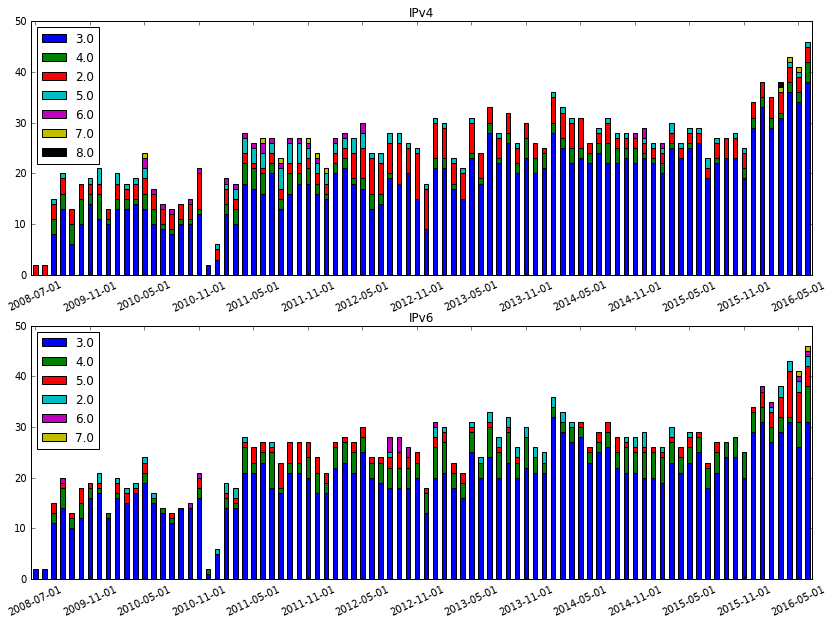

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=1)

plot_result4 = DataFrame.from_dict(result4, orient='index')
plot_result6 = DataFrame.from_dict(result6, orient='index')

plot4 = plot_result4.plot.bar(stacked=True, ax=axes[0], figsize=(14,10), ylim=(0,50), title='IPv4')
plot6 = plot_result6.plot.bar(stacked=True, ax=axes[1], figsize=(14,10), ylim=(0,50),title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.2 AS path average length?

/home/arif/Github/Thesis-Code/env/lib/python3.5/site-packages/numpy/lib/function_base.py:3823: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


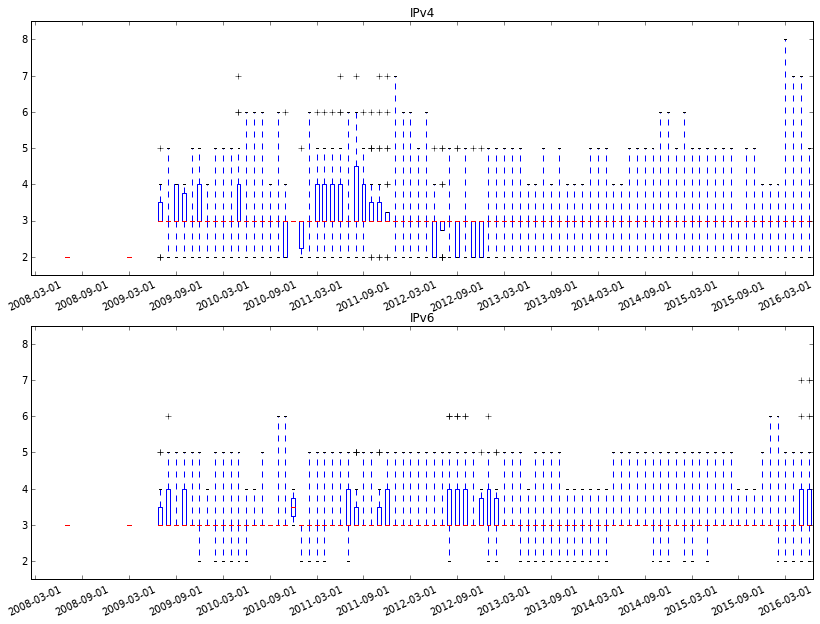

In [6]:
result4 = {}
result6 = {}
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    opened_file = DataFrame.from_csv(filename, sep='\t')
    if not opened_file.empty:
        res4 = opened_file['len4']
        res6 = opened_file['len6']
        result4[timestamp] = res4
        result6[timestamp] = res6
    else:
        result4[timestamp] = pd.Series()
        result6[timestamp] = pd.Series()

plot_result4 = DataFrame.from_dict(result4)
plot_result6 = DataFrame.from_dict(result6)


################
# Plot
################
fig, axes = plt.subplots(nrows=2, ncols=1)

plot4 = plot_result4.plot.box(figsize=(14,10), ax=axes[0], ylim=(1.5,8.5), title='IPv4')
plot6 = plot_result6.plot.box(figsize=(14,10), ax=axes[1], ylim=(1.5,8.5), title='IPv6')

n = 6

ticks = plot4.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot4.xaxis.get_ticklabels()]
plot4.xaxis.set_ticks(ticks[::n])
plot4.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

ticks = plot6.xaxis.get_ticklocs()
ticklabels = [datetime.fromtimestamp(int(l.get_text())).strftime('%Y-%m-%d') for l in plot6.xaxis.get_ticklabels()]
plot6.xaxis.set_ticks(ticks[::n])
plot6.xaxis.set_ticklabels(ticklabels[::n], rotation=25)

plt.show()

## RQ.3 Most frequently seen ASes on the path?

### IPv4

In [7]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path4']:
            # transform string of AS path into python's list
            path4 = item[1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            # exclude origin AS and probe AS
            for i in path4[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv4 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv4 AS paths (2008-07-01):

[*] Most frequently seen ASes in IPv4 AS paths (2009-03-01):

[*] Most frequently seen ASes in IPv4 AS paths (2009-07-01):
23148	6
4436	2
6939	2
1103	1
6453	1
3257	1
25512	1
3356	1
6730	1
1125	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-08-01):
23148	10
6939	3
3257	2
1103	1
4436	1
6453	1
25512	1
6730	1
3356	1
1125	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-09-01):
23148	5
3257	2
6939	2
5392	1
4436	1
25512	1
3356	1
6730	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-10-01):
23148	8
3549	3
3257	2
5392	1
20965	1
25512	1
6730	1
6939	1
3356	1
6453	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-11-01):
23148	8
4436	3
3257	2
5392	1
1125	1
6453	1
2852	1
6730	1
1103	1
3549	1

[*] Most frequently seen ASes in IPv4 AS paths (2009-12-01):
6939	5
8928	4
25192	4
23148	3
15685	2
4436	2
6453	2
2852	1
6730	1
48268	1

[*] Most frequently seen ASes in IPv4 AS paths (2010-01-01):
6939	4
23148	4
2852	1

### IPv6

In [8]:
from collections import Counter
def most_common(lst):
    """
    taken from here: http://stackoverflow.com/a/20872750/5658688
    """
    data = Counter(lst)
    return data.most_common()

for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    res = []
    if not opened_file.empty:
        for item in opened_file['path6']:
            # transform string of AS path into python's list
            path6 = item[1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            # exclude origin AS and probe AS
            for i in path6[1:-1]:
                res.append(i)

        results = most_common(res)
        print('\n[*] Most frequently seen ASes in IPv6 AS paths ({}):'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        for result in results[:10]:
            print('{}\t{}'.format(result[0], result[1])) 


[*] Most frequently seen ASes in IPv6 AS paths (2008-07-01):
1273	1
6939	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-03-01):
1273	1
6939	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-07-01):
6939	6
1273	5
3549	3
11537	1
4436	1
15685	1
29208	1
1103	1
3356	1
1125	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-08-01):
6939	8
1273	8
3549	4
15685	1
1103	1
11537	1
6453	1
30071	1
29208	1
3257	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-09-01):
1273	4
6939	4
3549	3
4436	2
11537	1
20965	1
29208	1
15685	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-10-01):
1273	7
6939	7
4436	4
3356	2
3549	2
11537	1
1299	1
20965	1
29208	1
15685	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-11-01):
6939	9
29208	4
1273	4
3549	2
11537	1
20965	1
1103	1
1125	1

[*] Most frequently seen ASes in IPv6 AS paths (2009-12-01):
29208	6
3549	5
1273	4
6939	2
1299	1
4436	1
6453	1
6730	1
20965	1

[*] Most frequently seen ASes in IPv6 AS paths (2010-01-01):
29208	8
1

## RQ.4a For shorter IPv6 path, which ASes frequently appear as transit?

In [9]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] > item[1]['len6']:
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            for asn in path6[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))

[*] at 2008-03-01:
[*] at 2008-04-01:
[*] at 2008-05-01:
[*] at 2008-06-01:
[*] at 2008-07-01:
[*] at 2008-08-01:
[*] at 2008-09-01:
[*] at 2008-10-01:
[*] at 2008-11-01:
[*] at 2008-12-01:
[*] at 2009-01-01:
[*] at 2009-02-01:
[*] at 2009-03-01:
[*] at 2009-04-01:
[*] at 2009-05-01:
[*] at 2009-06-01:
[*] at 2009-07-01:
[*] at 2009-08-01:
[*] at 2009-09-01:
	6939	1
[*] at 2009-10-01:
	6939	1
[*] at 2009-11-01:
	6939	1
[*] at 2009-12-01:
	3549	3
	29208	1
	6939	1
[*] at 2010-01-01:
	29208	1
[*] at 2010-02-01:
	3549	1
[*] at 2010-03-01:
[*] at 2010-04-01:
[*] at 2010-05-01:
	29208	2
	3549	2
	20080	1
	1103	1
	20965	1
[*] at 2010-06-01:
	6939	2
	3257	1
	6730	1
[*] at 2010-07-01:
	3257	1
	6730	1
	6939	1
[*] at 2010-08-01:
	29208	1
	3257	1
	6730	1
	6695	1
[*] at 2010-09-01:
	3257	1
[*] at 2010-10-01:
	3257	1
[*] at 2010-11-01:
	30781	1
[*] at 2010-12-01:
[*] at 2011-01-01:
	6939	1
[*] at 2011-02-01:
	29208	1
	30781	1
[*] at 2011-03-01:
	30781	2
	29208	1
	1273	1
[*] at 2011-04-01:
	29208	2
	6

## RQ.4b For shorter IPv6 path, how different is it?

In [10]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) > len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path4) - len(path6), (len(path4) - len(path6)) / len(path4) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-08-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-09-01
-----------------------------------

## RQ.5a For shorter IPv4 path, which ASes frequently appear as transit?¶

In [11]:
for file in sorted(os.listdir('datasets/m/')):
    timestamp = int(file.split('-')[0])
    filename = 'datasets/m/{}'.format(file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp= []
    for item in opened_file.iterrows():
        if item[1]['len4'] < item[1]['len6']:
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            for asn in path4[1:-1]:
                temp.append(asn)

    results = most_common(temp)
    print('\n[*] at {}:'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    for result in results[:5]:
        print('\t{}\t{}'.format(result[0], result[1]))


[*] at 2008-03-01:
	1299	2

[*] at 2008-04-01:

[*] at 2008-05-01:
	1299	1

[*] at 2008-06-01:

[*] at 2008-07-01:

[*] at 2008-08-01:

[*] at 2008-09-01:

[*] at 2008-10-01:

[*] at 2008-11-01:

[*] at 2008-12-01:

[*] at 2009-01-01:

[*] at 2009-02-01:

[*] at 2009-03-01:

[*] at 2009-04-01:

[*] at 2009-05-01:

[*] at 2009-06-01:

[*] at 2009-07-01:

[*] at 2009-08-01:

[*] at 2009-09-01:

[*] at 2009-10-01:

[*] at 2009-11-01:

[*] at 2009-12-01:

[*] at 2010-01-01:
	3257	1

[*] at 2010-02-01:
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-03-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-04-01:
	3257	2
	1125	1
	1103	1

[*] at 2010-05-01:
	6453	1
	3257	1
	6730	1
	1125	1
	1103	1

[*] at 2010-06-01:
	3257	2
	6730	1
	1125	1
	1103	1

[*] at 2010-07-01:

[*] at 2010-08-01:

[*] at 2010-09-01:

[*] at 2010-10-01:
	2200	1
	20965	1
	27750	1

[*] at 2010-11-01:
	2200	1
	24490	1
	20965	1

[*] at 2010-12-01:

[*] at 2011-01-01:
	2200	1
	24490	1
	20965	1

[*] at 2011-02-01:
	2200	1
	24490	1
	

## RQ.5b For shorter IPv4 path, how different is it?

In [12]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    
    for item in opened_file.iterrows():
        # transform string into list
        path4 = item[1]['path4'][1:-1].split(',')
        path4 = [int(i.strip()) for i in path4]
        path6 = item[1]['path6'][1:-1].split(',')
        path6 = [int(i.strip()) for i in path6]
        if len(path4) < len(path6):
            print('{0}\t{1}\t{2}\t{3}\t{4:.2f}%'.format(item[0], len(path4), len(path6), len(path6) - len(path4), (len(path6) - len(path4)) / len(path6) * 100))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
2497	2	3	1	33.33%
19151	2	3	1	33.33%

---------------------------------------------------------------
 date: 2008-08-01
---------------------------------------------------------------

---------------------------------------------------------------
 date: 2008-09-0

## RQ.6 For peers with same AS path length but different path, how different is it?

In [36]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')

    temp = []
    print('\n---------------------------------------------------------------')
    print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
    print('---------------------------------------------------------------')
    for item in opened_file.iterrows():
        if len(item[1]['path4']) == len(item[1]['path6']):
            # transform string into list
            path4 = item[1]['path4'][1:-1].split(',')
            path4 = [int(i.strip()) for i in path4]
            path6 = item[1]['path6'][1:-1].split(',')
            path6 = [int(i.strip()) for i in path6]
            
            diff_counter = 0
            path_length = len(path4)
            for i in range(0, path_length):
                if path4[i] != path6[i]:
                    temp.append(path6[i])
                    diff_counter += 1
            diff_pct = (diff_counter / path_length) * 100
            print('Peer {0}: \tlength:{1} \tdifference: {2:.2f}%'.format(item[0], path_length, diff_pct))
            

    print('\nMost common ASes appear in IPv6 path that differs with IPv4 path:')
    results = most_common(temp)
    for result in results:
        print('\t{}\t{}'.format(result[0], result[1]))


---------------------------------------------------------------
 date: 2008-03-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-04-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-05-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-06-01
---------------------------------------------------------------

Most common ASes appear in IPv6 path that differs with IPv4 path:

---------------------------------------------------------------
 date: 2008-07-01
-------------------------------------------------------------

## RQ.7 Can we correlate the path difference to their physical location?

In [38]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        peer_location = opened_file.groupby('collector')
        result = peer_location['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    2
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
collector
Palo Alto, USA    2
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam            3
AMS-IX and NL-IX, Amsterdam    3
VIX, Vienna                    2
New York (NY), USA             2
Frankfurt, Germany             2
Stockholm, Sweden              1
Moscow, Russia                 1
CIXP, Geneva                   1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-08-01
------------------------------------------------

### which collectors see the most peers with shorter IPv6 path?

In [40]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v6_shorter = opened_file[opened_file.len4 > opened_file.len6].groupby('collector')
        result = v6_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-08-01
---------------------------------------------------------------
Series([], Name: collector, dtype: int64)

---------------------------------------------------------------
 date: 2009-09-01
---------------------------------------------------------------
collector
Milan, Italy    1
Name: collector, dtype: int64

--------------------------------------

### which collectors see the most peers with shorter IPv4 path?

In [41]:
for file in sorted(os.listdir(csv_dir)):
    timestamp = int(file.split('-')[0])
    filename = '{}{}'.format(csv_dir, file)
    
    opened_file = DataFrame.from_csv(filename, sep='\t')
    
    if not opened_file.empty:
        print('\n---------------------------------------------------------------')
        print(' date: {}'.format(datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')))
        print('---------------------------------------------------------------')
        v4_shorter = opened_file[opened_file.len4 < opened_file.len6].groupby('collector')
        result = v4_shorter['collector'].count().sort_values(ascending=False)
        print(result)


---------------------------------------------------------------
 date: 2008-07-01
---------------------------------------------------------------
collector
New York (NY), USA    2
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-03-01
---------------------------------------------------------------
collector
Palo Alto, USA    2
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-07-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam    2
New York (NY), USA     1
Frankfurt, Germany     1
Name: collector, dtype: int64

---------------------------------------------------------------
 date: 2009-08-01
---------------------------------------------------------------
collector
RIPE NCC, Amsterdam            3
New York (NY), USA             1
LINX, London                   1
Frankfurt, Germany             1
AMS-IX and NL-IX, Amsterdam    